<h1><b>FINAL PROJECT BIG DATA PREDICTIVE ANALYTICS LANJUT</b></h1>
  <p><b>ANGGOTA KELOMPOK : </b><p>
<ul>
  <li>Haikal Raditya Fadhilah (21.11.3910)</li>
  <li>Sulthan Asyarf Donison (21.11.3902)</li>
  <li></li>
  <li></li>
<ul>

<h2><b>INSTALL PYSPARK</b></h2>

In [469]:
# !pip install pyspark

<h2><b>IMPORT LIBRARY</b></h2>

In [470]:
from pyspark.sql import SparkSession
import pyspark
from pyspark.sql.functions import col,isnan,when,count
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from pyspark.sql.types import FloatType,DoubleType

<h2><b>CREATE SESSION SPARK</b></h2>

In [471]:
spark = SparkSession.builder.getOrCreate()

<h2><b>IMPORT DATASET</b></h2>

In [472]:
path = './ShanghaiPM20100101_20151231.csv'
df = spark.read.csv(path,inferSchema=True,header=True)

<h2><b>PREPARE DATASET</b></h2>

<h3><b>MELIHAT CONTOH DATASET</b></h3>

In [473]:
df.show(5)

+---+----+-----+---+----+------+---------+----------+--------+----+-----+------+----+----+---+-------------+-----+
| No|year|month|day|hour|season|PM_Jingan|PM_US Post|PM_Xuhui|DEWP| HUMI|  PRES|TEMP|cbwd|Iws|precipitation|Iprec|
+---+----+-----+---+----+------+---------+----------+--------+----+-----+------+----+----+---+-------------+-----+
|  1|2010|    1|  1|   0|     4|       NA|        NA|      NA|  -6|59.48|1026.1|   1|  cv|  1|            0|    0|
|  2|2010|    1|  1|   1|     4|       NA|        NA|      NA|  -6|59.48|1025.1|   1|  SE|  2|            0|    0|
|  3|2010|    1|  1|   2|     4|       NA|        NA|      NA|  -7|59.21|1025.1|   0|  SE|  4|            0|    0|
|  4|2010|    1|  1|   3|     4|       NA|        NA|      NA|  -6|63.94|  1024|   0|  SE|  5|            0|    0|
|  5|2010|    1|  1|   4|     4|       NA|        NA|      NA|  -6|63.94|  1023|   0|  SE|  8|            0|    0|
+---+----+-----+---+----+------+---------+----------+--------+----+-----+------+

<h3><b>MENGHAPUS COLUMN YANG KURANG BERGUNA</b></h3>

In [474]:
df = df.drop('No','year','month','hour','day')

<h3><b>MELIHAT JUMLAH KOLOM DAN BARIS DATASET</b></h3>

In [475]:
print(f"Jumlah Baris Dalam Dataset : {df.count()} Baris")
print(f"Jumlah Kolom Dalam Dataset : {len(df.columns)}")

Jumlah Baris Dalam Dataset : 52584 Baris
Jumlah Kolom Dalam Dataset : 12


<h3><b>MELIHAT TIPE DATA DARI SETIAP KOLOM</b></h3>

In [476]:
df.printSchema()

root
 |-- season: integer (nullable = true)
 |-- PM_Jingan: string (nullable = true)
 |-- PM_US Post: string (nullable = true)
 |-- PM_Xuhui: string (nullable = true)
 |-- DEWP: string (nullable = true)
 |-- HUMI: string (nullable = true)
 |-- PRES: string (nullable = true)
 |-- TEMP: string (nullable = true)
 |-- cbwd: string (nullable = true)
 |-- Iws: string (nullable = true)
 |-- precipitation: string (nullable = true)
 |-- Iprec: string (nullable = true)



<h3><b>KONVERSI TIPE DATA UNTUK MENGHITUNG NILAI NULL</b></h3>

In [477]:
numeric_columns = ["season","PM_Jingan", "PM_US Post", "PM_Xuhui", "DEWP", "HUMI", "PRES", "TEMP", "Iws", "precipitation", "Iprec"]
for col_name in numeric_columns:
    df = df.withColumn(col_name, df[col_name].cast(FloatType()))

<h3><b>LIHAT KEMBALI SEMUA TIPE DATA DARI DATASET</b></h3>

In [488]:
df.printSchema()

root
 |-- season: float (nullable = true)
 |-- PM_Jingan: float (nullable = true)
 |-- PM_US Post: float (nullable = true)
 |-- PM_Xuhui: float (nullable = true)
 |-- DEWP: float (nullable = true)
 |-- HUMI: float (nullable = true)
 |-- PRES: float (nullable = true)
 |-- TEMP: float (nullable = true)
 |-- cbwd: string (nullable = true)
 |-- Iws: float (nullable = true)
 |-- precipitation: float (nullable = true)
 |-- Iprec: float (nullable = true)



<h3><b>MELIHAT DATA NULL DARI SETIAP KOLOM</b></h3>

In [478]:
df.select([count(when((col(c).isNull() | (col(c) == 'NA')), c)).alias(c) for c in df.columns]).toPandas().T

,0
season,0
PM_Jingan,27884
PM_US Post,18545
PM_Xuhui,27395
DEWP,13
HUMI,13
PRES,28
TEMP,13
cbwd,12
Iws,12


<h3><b>MENGHAPUS DATA NULL ATAU 'NA'</b></h3>

In [479]:
df = df.na.drop()

<h3><b>CEK KEMBALI JUMLAH NULL</b></h3>

In [487]:
df.select([count(when((col(c).isNull() | (col(c) == 'NA')), c)).alias(c) for c in df.columns]).toPandas().T

,0
season,0
PM_Jingan,0
PM_US Post,0
PM_Xuhui,0
DEWP,0
HUMI,0
PRES,0
TEMP,0
cbwd,0
Iws,0


<h2><b>DATA PRE-PROCESSING</b></h2>

<h3><b>MELIHAT DATA 5 TERATAS</b></h3>

In [480]:
df.show(5)

+------+---------+----------+--------+----+-----+------+----+----+----+-------------+-----+
|season|PM_Jingan|PM_US Post|PM_Xuhui|DEWP| HUMI|  PRES|TEMP|cbwd| Iws|precipitation|Iprec|
+------+---------+----------+--------+----+-----+------+----+----+----+-------------+-----+
|   4.0|     66.0|      70.0|    71.0|-5.0| 69.0|1023.0| 0.0|  SW|60.0|          0.0|  0.0|
|   4.0|     67.0|      76.0|    72.0|-5.0| 69.0|1023.0| 0.0|  SW|62.0|          0.0|  0.0|
|   4.0|     73.0|      78.0|    74.0|-4.0|74.41|1023.0| 0.0|  SW|65.0|          0.0|  0.0|
|   4.0|     75.0|      77.0|    77.0|-4.0|80.04|1023.0|-1.0|  SW|68.0|          0.0|  0.0|
|   4.0|     73.0|      78.0|    80.0|-4.0|80.04|1023.0|-1.0|  SW|70.0|          0.0|  0.0|
+------+---------+----------+--------+----+-----+------+----+----+----+-------------+-----+
only showing top 5 rows



<h3><b>MELIHAT DESKRIPSI DATASET</b></h3>

In [481]:
df.describe().toPandas()

,summary,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,count,21436,21436,21436,21436,21436,21436,21436,21436,21436,21436,21436,21436
1,mean,2.46911737264415,57.964545624183614,54.13463332711327,58.57170181003919,11.19401940660571,68.67215928686134,1016.0598992349319,17.61802575107296,None,48.276497480873296,0.13309852619688275,0.8714825523310599
2,stddev,1.1356873089307888,48.13816570718253,43.27717635642927,49.22551599499996,9.503135826817415,18.100382924812493,8.9562737630813,8.982793065352586,None,67.69839058412309,1.030225879947247,6.79496023499355
3,min,1.0,1.0,1.0,1.0,-17.0,13.09,990.0,-3.0,NE,0.0,0.0,0.0
4,max,4.0,607.0,514.0,636.0,28.0,100.0,1040.0,41.0,cv,608.0,61.6,226.4


<h3><b>MELIHAT JUMLAH DATA UNIQUE TIAP KOLOM</b></h3>

In [482]:
for x in df.columns:
    print(f"Kolom '{x}' Memiliki Jumlah Data Unique Sebanyak : {df.dropDuplicates([x]).select(x).count()}")

Kolom 'season' Memiliki Jumlah Data Unique Sebanyak : 4


Kolom 'PM_Jingan' Memiliki Jumlah Data Unique Sebanyak : 339


Kolom 'PM_US Post' Memiliki Jumlah Data Unique Sebanyak : 310


Kolom 'PM_Xuhui' Memiliki Jumlah Data Unique Sebanyak : 340


Kolom 'DEWP' Memiliki Jumlah Data Unique Sebanyak : 46


Kolom 'HUMI' Memiliki Jumlah Data Unique Sebanyak : 826


Kolom 'PRES' Memiliki Jumlah Data Unique Sebanyak : 51


Kolom 'TEMP' Memiliki Jumlah Data Unique Sebanyak : 45


Kolom 'cbwd' Memiliki Jumlah Data Unique Sebanyak : 5


Kolom 'Iws' Memiliki Jumlah Data Unique Sebanyak : 429


Kolom 'precipitation' Memiliki Jumlah Data Unique Sebanyak : 128


Kolom 'Iprec' Memiliki Jumlah Data Unique Sebanyak : 389


<h2><b>VISUALISASI DATA</b></h2>

<h3><b>MELIHAT VISUALISASI DATA CORELASI ANTAR VARIABEL</b></h3>

In [483]:
features = [col_name for col_name, col_type in df.dtypes if col_type in ['int', 'double','float']]
features

['season',
 'PM_Jingan',
 'PM_US Post',
 'PM_Xuhui',
 'DEWP',
 'HUMI',
 'PRES',
 'TEMP',
 'Iws',
 'precipitation',
 'Iprec']

In [484]:
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
df_assembler = vector_assembler.transform(df).select("features")

In [485]:
matrix = Correlation.corr(df_assembler,"features").head()

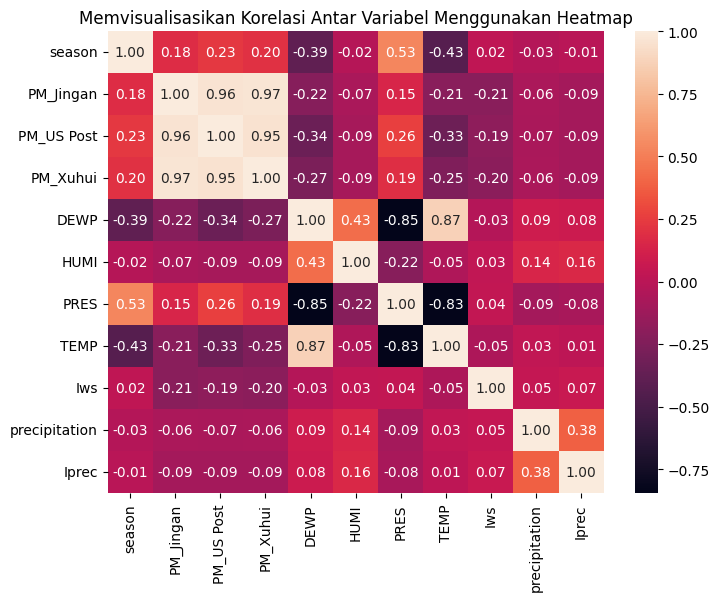

In [486]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(matrix[0].toArray(),columns=features,index=features),fmt='.2f',annot=True, xticklabels=features, yticklabels=features)
plt.title("Memvisualisasikan Korelasi Antar Variabel Menggunakan Heatmap")
plt.show()

<h2><b>BUILDING MODEL PREDICTION</b></h2>